# Drought Network Splicing
3.28.2023
a. stein

Here I want to enable splicing based on thresholds

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../../')
from ndrought import drought_network_v12 as dnet

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_3603431/2339562268.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Let's get our simpler test case up in here.

In [2]:
def tick(matrix):
    new_state = np.copy(matrix)

    i_dim, j_dim = matrix.shape

    for i in range(i_dim):
        for j in range(j_dim):
            north = matrix[i][j-1] if j>0 else 0
            south = matrix[i][j+1] if j<(j_dim-1) else 0
            west = matrix[i+1][j] if i<(i_dim-1) else 0
            east = matrix[i-1][j] if i>0 else 0
            se = matrix[i+1][j+1] if i<(i_dim-1) and j<(j_dim-1) else 0
            sw = matrix[i+1][j-1] if i<(i_dim-1) and j>0 else 0
            ne = matrix[i-1][j+1] if i>0 and j<(j_dim-1) else 0
            nw = matrix[i-1][j-1] if i>0 and j>0 else 0
            neighbors = np.sum([north, south, west, east, se, sw, ne, nw])

            # rules
            if matrix[i][j] == 0 and neighbors == 3: # reproduction
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors < 2: # underpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors > 3: # overpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors == 2: # survives
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors == 3: # also survives
                new_state[i][j] = 1

    return new_state

In [3]:
# this was originally generated randomly using the same method method as
# before, but I have now hard coded it to have a consistent test example
test_matrix = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [0, 0, 1, 0, 1]
])

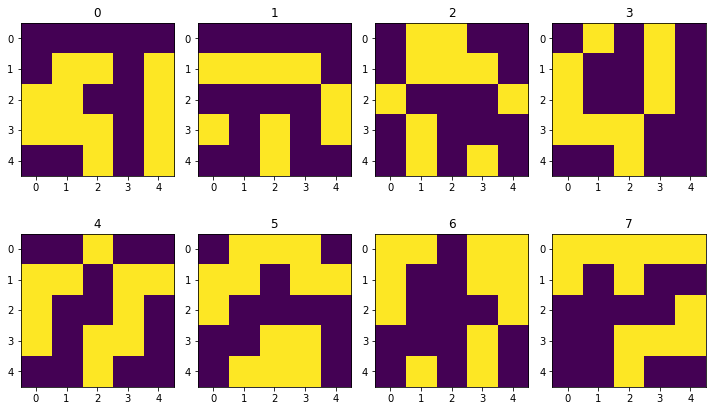

In [4]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

test_series = []
plot_matrix = test_matrix

for i, ax in enumerate(axs.ravel()):
    test_series.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

test_series = np.array(test_series)

plt.tight_layout()

In [5]:
plot_matrix = test_matrix
test_series = []
for i in np.arange(8):
    test_series.append(plot_matrix)
    plot_matrix = tick(plot_matrix)
test_series = np.array(test_series)

In [6]:
test_dnet = dnet.DroughtNetwork(test_series.copy())

Creating Network: drought_network:   0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
to_remove = []

for node in test_dnet.nodes:
    if node.area == 1:
        to_remove.append(node)
        print(node)

time: 1, id: 3, futures: []
time: 2, id: 6, futures: []
time: 6, id: 13, futures: []


In [8]:
for node in to_remove:
    print(node)
    for past_node in node.past:
        print(past_node)
        past_node.future.remove(node)
        print(past_node)
    for future_node in node.future:
        future_node.past.remove(node)
    test_dnet.nodes.remove(node)
    print()

time: 1, id: 3, futures: []
time: 0, id: 0, futures: [2, 3, 4]
time: 0, id: 0, futures: [2, 4]

time: 2, id: 6, futures: []

time: 6, id: 13, futures: []
time: 5, id: 10, futures: [12, 13]
time: 5, id: 10, futures: [12]



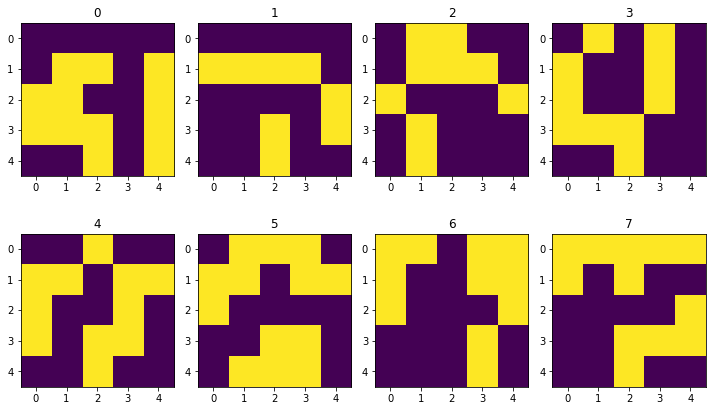

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

test_series = test_dnet.to_array()

for i, ax in enumerate(axs.ravel()):
    ax.imshow(test_series[i, :, :])

    ax.set_title(i)

plt.tight_layout()

In [10]:
test_dnet.nodes

[time: 0, id: 0,
 time: 0, id: 1,
 time: 1, id: 2,
 time: 1, id: 4,
 time: 2, id: 5,
 time: 3, id: 7,
 time: 4, id: 8,
 time: 5, id: 9,
 time: 5, id: 10,
 time: 6, id: 11,
 time: 6, id: 12,
 time: 7, id: 14,
 time: 7, id: 15]

Cool, that works.

In [11]:
plot_matrix = test_matrix
test_series = []
for i in np.arange(8):
    test_series.append(plot_matrix)
    plot_matrix = tick(plot_matrix)
test_series = np.array(test_series)

test_dnet = dnet.DroughtNetwork(test_series.copy())

Creating Network: drought_network:   0%|          | 0/8 [00:00<?, ?it/s]

In [12]:
def area_thresh_removal(net, thresh:int):
    to_remove = []
    for node in net.nodes:
        if node.area <= thresh:
            to_remove.append(node)
    
    for node in to_remove:
        for past_node in node.past:
            past_node.future.remove(node)
        for future_node in node.future:
            future_node.past.remove(node)
        net.nodes.remove(node)
        if node in net.origins:
            net.origins.remove(node)

    for node in net.nodes:
        if len(node.past) == 0 and not node in net.origins:
            net.origins.append(node)

In [13]:
area_thresh_removal(test_dnet, 1)

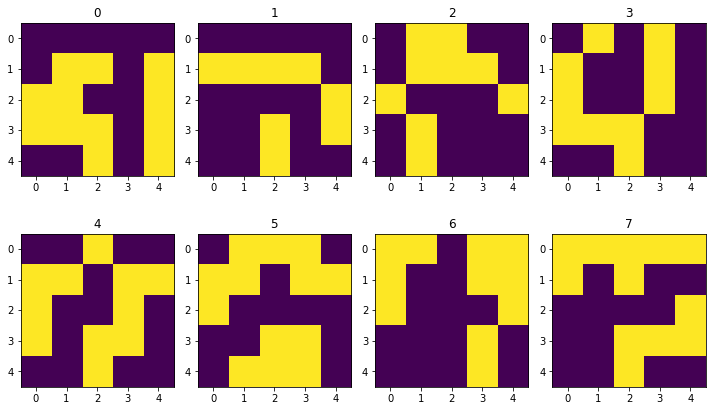

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

test_series = test_dnet.to_array()

for i, ax in enumerate(axs.ravel()):
    ax.imshow(test_series[i, :, :])

    ax.set_title(i)

plt.tight_layout()

In [15]:
test_dnet.origins

[time: 0, id: 0, time: 0, id: 1]

Now for splicing threads

In [16]:
plot_matrix = test_matrix
test_series = []
for i in np.arange(8):
    test_series.append(plot_matrix)
    plot_matrix = tick(plot_matrix)
test_series = np.array(test_series)

test_dnet = dnet.DroughtNetwork(test_series.copy())

Creating Network: drought_network:   0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
for node in test_dnet.nodes:
    #print(node)
    to_splice = []
    for future_node in node.future:
        if future_node.area <= 0.5*node.area:
            to_splice.append(future_node)
    for splice_node in to_splice:
        print(splice_node)
        node.future.remove(splice_node)
        splice_node.past.remove(node)
        if len(splice_node.past) == 0:
            test_dnet.origins.append(splice_node)
            print(test_dnet.origins)
        
    #print(node)
    #print()

time: 1, id: 3, futures: []
[time: 0, id: 0, time: 0, id: 1, time: 2, id: 6, time: 1, id: 3]
time: 1, id: 4, futures: []
[time: 0, id: 0, time: 0, id: 1, time: 2, id: 6, time: 1, id: 3, time: 1, id: 4]
time: 5, id: 10, futures: [12, 13]
[time: 0, id: 0, time: 0, id: 1, time: 2, id: 6, time: 1, id: 3, time: 1, id: 4, time: 5, id: 10]
time: 6, id: 11, futures: [14]
[time: 0, id: 0, time: 0, id: 1, time: 2, id: 6, time: 1, id: 3, time: 1, id: 4, time: 5, id: 10, time: 6, id: 11]
time: 6, id: 13, futures: []
[time: 0, id: 0, time: 0, id: 1, time: 2, id: 6, time: 1, id: 3, time: 1, id: 4, time: 5, id: 10, time: 6, id: 11, time: 6, id: 13]


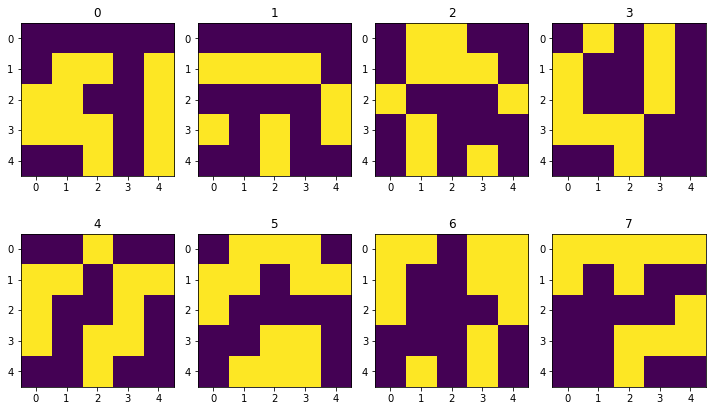

In [18]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

test_series = test_dnet.to_array()

for i, ax in enumerate(axs.ravel()):
    ax.imshow(test_series[i, :, :])

    ax.set_title(i)

plt.tight_layout()

In [19]:
test_dnet.origins

[time: 0, id: 0,
 time: 0, id: 1,
 time: 2, id: 6,
 time: 1, id: 3,
 time: 1, id: 4,
 time: 5, id: 10,
 time: 6, id: 11,
 time: 6, id: 13]

In [20]:
def area_thresh_splice(net, thresh):
    for node in net.nodes:
        to_splice = []
        for future_node in node.future:
            if future_node.area <= thresh*node.area:
                to_splice.append(future_node)
        
        for splice_node in to_splice:
            node.future.remove(splice_node)
            splice_node.past.remove(node)
            if len(splice_node.past) == 0:
                net.origins.append(splice_node)

In [21]:
plot_matrix = test_matrix
test_series = []
for i in np.arange(8):
    test_series.append(plot_matrix)
    plot_matrix = tick(plot_matrix)
test_series = np.array(test_series)

test_dnet = dnet.DroughtNetwork(test_series.copy())

Creating Network: drought_network:   0%|          | 0/8 [00:00<?, ?it/s]

In [22]:
test_dnet.origins

[time: 0, id: 0, time: 0, id: 1, time: 2, id: 6]

In [23]:
area_thresh_splice(test_dnet, 0.5)

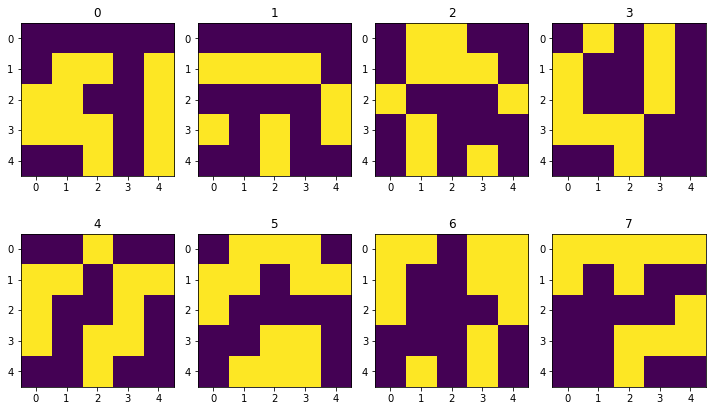

In [24]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

test_series = test_dnet.to_array()

for i, ax in enumerate(axs.ravel()):
    ax.imshow(test_series[i, :, :])

    ax.set_title(i)

plt.tight_layout()

In [25]:
test_dnet.origins

[time: 0, id: 0,
 time: 0, id: 1,
 time: 2, id: 6,
 time: 1, id: 3,
 time: 1, id: 4,
 time: 5, id: 10,
 time: 6, id: 11,
 time: 6, id: 13]

In [26]:
area_thresh_removal(test_dnet, 1)

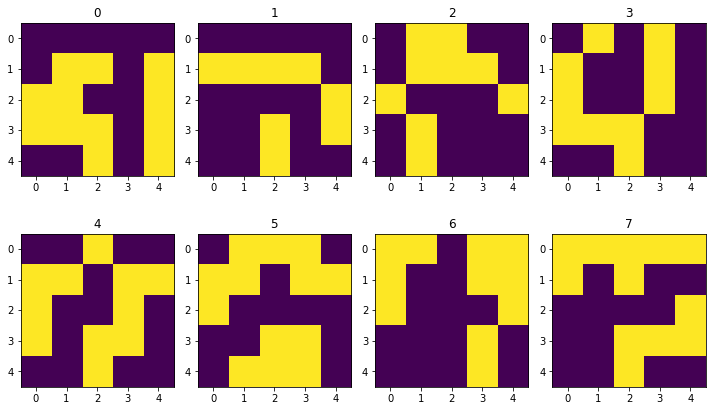

In [27]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

test_series = test_dnet.to_array()

for i, ax in enumerate(axs.ravel()):
    ax.imshow(test_series[i, :, :])

    ax.set_title(i)

plt.tight_layout()

In [28]:
test_dnet.origins

[time: 0, id: 0,
 time: 0, id: 1,
 time: 1, id: 4,
 time: 5, id: 10,
 time: 6, id: 11]